In [3]:
import numpy as np
import xarray as xr
import gsw
from xgcm.grid import Grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds = xr.open_dataset('1995-01.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 31, latitude: 171, longitude: 173)
Coordinates:
  * latitude   (latitude) float32 7.375 7.625 7.875 8.125 ... 49.38 49.62 49.88
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 1995-01-31
  * longitude  (longitude) float32 -98.12 -97.88 -97.62 ... -55.62 -55.38 -55.12
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    crs        int32 ...
    sla        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    err_sla    (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

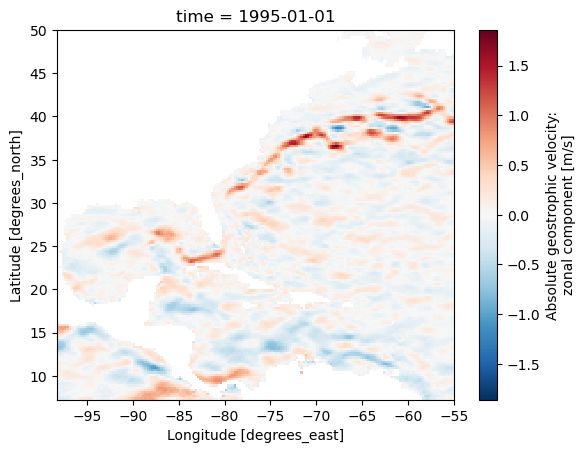

In [12]:
ds.ugos.isel(time=0).plot()

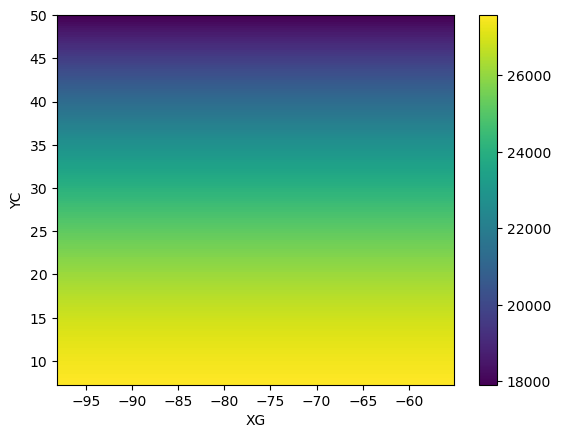

In [10]:
lo, la = np.meshgrid(ds.longitude, ds.latitude)

dx = xr.DataArray(gsw.distance(lo, la, axis=1), dims=['YC','XG'],
                  coords={'YC':ds.latitude.data,
                          'XG':.5*(ds.longitude.data[1:]
                                   + ds.longitude.data[:-1])}
                 )
dy = xr.DataArray(gsw.distance(lo, la, axis=0), dims=['YG','XC'],
                  coords={'YG':.5*(ds.latitude.data[1:]
                                   + ds.latitude.data[:-1]),'XC':ds.longitude.data}
                 )
dx.plot()

In [14]:
ug = xr.DataArray(ds.ugos.data, dims=['time','YC','XC'],
                  coords={'YC':ds.latitude.data,'XC':ds.longitude.data})
vg = xr.DataArray(ds.vgos.data, dims=['time','YC','XC'],
                  coords={'YC':ds.latitude.data,'XC':ds.longitude.data})
ds_new = ug.to_dataset(name='ug')
ds_new['vg'] = vg
ds_new.coords['dx'] = dx
ds_new.coords['dy'] = dy
ds_new

<xarray.Dataset>
Dimensions:  (YC: 171, XC: 173, time: 31, XG: 172, YG: 170)
Coordinates:
  * YC       (YC) float32 7.375 7.625 7.875 8.125 ... 49.12 49.38 49.62 49.88
  * XC       (XC) float32 -98.12 -97.88 -97.62 -97.38 ... -55.62 -55.38 -55.12
  * XG       (XG) float32 -98.0 -97.75 -97.5 -97.25 ... -55.75 -55.5 -55.25
    dx       (YC, XG) float64 2.757e+04 2.757e+04 ... 1.792e+04 1.792e+04
  * YG       (YG) float32 7.5 7.75 8.0 8.25 8.5 ... 48.75 49.0 49.25 49.5 49.75
    dy       (YG, XC) float64 2.78e+04 2.78e+04 2.78e+04 ... 2.78e+04 2.78e+04
Dimensions without coordinates: time
Data variables:
    ug       (time, YC, XC) float64 -0.1995 -0.2283 -0.2352 ... 0.0049 0.0009
    vg       (time, YC, XC) float64 0.1665 0.1098 0.1231 ... nan -0.005 0.0161

In [15]:
coords={
        "X": {"center": "XC", "inner": "XG"},
        "Y": {"center": "YC", "inner": "YG"},
       }
grid = Grid(ds_new, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> inner
  * inner    XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> inner
  * inner    YG --> center

In [17]:
vg_x = grid.diff(ds_new.vg,'X',boundary='extend') / dx
ug_y = grid.diff(ds_new.ug,'Y',boundary='extend') / dy
vort = (grid.interp(vg_x,'X',boundary='extend')
        - grid.interp(ug_y,'Y',boundary='extend')
       )
vort

<xarray.DataArray (time: 31, YC: 171, XC: 173)>
array([[[-3.43803375e-06, -4.23332322e-06, -5.39772418e-06, ...,
         -5.39148762e-07,  9.83297692e-06,  7.97020089e-06],
        [-6.82876166e-07, -2.82596589e-06, -4.54546134e-06, ...,
          5.08827058e-06,  1.13152312e-05,  1.11447859e-05],
        [-2.65684719e-06, -1.71932661e-06, -8.40083716e-07, ...,
          1.09353347e-05,  8.03866486e-06,  9.20899621e-06],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  2.08105952e-06]],

       [[-4.39679515e-06, -4.87450679e-06, -4.76155417e-06, ...,
          4.93287857e-06,  5.24314180e-06,  2.90380125e-06],
        [-1.85372423e-06, -2.55975065e-06, -3.36297247e-06, ...,
          8.75270312e-06,  8.95824587e-06,  5.44860300e-06],
        [-2.36770959e-06, -9.66312197e-07,  1.64311893e-06, ...,
          1.03309570e-05,  7.28803384e-06,  6.47170604e-06],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan, -1.79498728e-07]],

       [[-6.37226192e-07, -1.75952681e-06, -8.80128953e-07, ...,
         -1.72260917e-06, -6.16295002e-06, -3.84822533e-06],
        [-1.82950300e-06, -1.85661102e-06, -7.07380254e-07, ...,
         -3.62075312e-06, -6.26436308e-06, -3.78991289e-06],
        [-3.87290503e-07, -9.55300891e-07, -2.27829557e-06, ...,
         -1.97283256e-06, -2.34686283e-06, -6.28617687e-06],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,  5.51850355e-07]]])
Coordinates:
  * YC       (YC) float32 7.375 7.625 7.875 8.125 ... 49.12 49.38 49.62 49.88
  * XC       (XC) float32 -98.12 -97.88 -97.62 -97.38 ... -55.62 -55.38 -55.12
Dimensions without coordinates: time

In [ ]:
f = xr.apply_ufunc()
vort.isel(time=0).plot